# Get The Dataset

In [1]:

# # !wget https://raw.githubusercontent.com/grananqvist/Machine-Learning-Web-Application-Firewall-and-Dataset/master/data/payloads.csv
!wget https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/badqueries.txt
!wget https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/goodqueries.txt

--2020-04-20 10:59:34--  https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/badqueries.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3374922 (3.2M) [text/plain]
Saving to: ‘badqueries.txt’

badqueries.txt      100%[===================>]   3.22M  11.5MB/s    in 0.3s    

2020-04-20 10:59:35 (11.5 MB/s) - ‘badqueries.txt’ saved [3374922/3374922]

--2020-04-20 10:59:38--  https://raw.githubusercontent.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/master/goodqueries.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.


---
# Init pyspark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!rm spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# path variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# find pyspark library
import findspark
findspark.init()


---

In [3]:

import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, IntegerType
from pyspark.sql.functions import udf

from pyspark.ml.feature import CountVectorizer, VectorAssembler, IDF
from pyspark.ml import Pipeline
from pyspark.ml.linalg import VectorUDT,DenseVector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import PCA, Tokenizer, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from urllib.parse import unquote

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
APP_NAME = "BigData"
conf = pyspark.SparkConf().setAll([ ('spark.app.name', APP_NAME),('spark.executor.memory', '8g'), ('spark.cores.max', '2'), ('spark.driver.memory','8g')])
sc = SparkContext(conf=conf)
sqlc = SQLContext(sc)
sc

<SparkContext master=local[*] appName=BigData>

# Load Data

The dataset we used was collected from github: 
- https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall/blob/master/script.py

The dataset consists on more than 1 M entries

In [0]:
good = sc.textFile("goodqueries.txt").map(lambda line: Row(is_malicious=0.0,payload=str(unquote(line))[1:])).distinct()
bad = sc.textFile("badqueries.txt").map(lambda line: Row(is_malicious=1.0,payload=str(unquote(line))[1:])).distinct()
mySchema = StructType([StructField("is_malicious", DoubleType(), True),StructField("payload", StringType(), True)])

df = sqlc.createDataFrame(good.union(bad), mySchema).cache()

In [0]:
# dfPD = pd.read_csv('payloads.csv')
# dfPD = dfPD.drop(columns=['injection_type'])
# mySchema = StructType([ StructField("doc_id", IntegerType(), True) ,StructField("payload", StringType(), True),StructField("is_malicious", DoubleType(), True)])
# df = sqlc.createDataFrame(dfPD,schema=mySchema)
# df = df.select('doc_id','is_malicious','payload')

---


# Preprocess Data
## Feature extarcting
> models can't evaluate string so we will want to turn the string into numerical vectors using the HashingTF and IDF provided by spark. First of all, words won't help in http queries so we will turn each query into bigrams to exapnad the features space and treating each by gram as a word. This approach will expand the word bucket.An Example for bi-gram is given below.

In [7]:
def to_ngram(payload_obj):
    n=2
    payload = str(payload_obj)
    ngrams = ''
    for i in range(0,len(payload)-n + 1):
        ngrams += payload[i:i+n]+ ' '
    return ngrams[:-1]


print('EXAMPLE: bigram of the word <script>:')
to_ngram("<script>")

EXAMPLE: bigram of the word <script>:


'<s sc cr ri ip pt t>'

In [0]:
#to_ngrams
ngrams = udf(to_ngram, StringType())
df = df.withColumn('ngrams', ngrams(df['payload']))

# tokenize
tokenizer = Tokenizer().setInputCol("ngrams").setOutputCol("tokens")
wordsData = tokenizer.transform(df)

# vectorize
vectorizer = CountVectorizer(inputCol='tokens', outputCol='vectorizer').fit(wordsData)
wordsData = vectorizer.transform(wordsData)

# calculate scores
idf = IDF(minDocFreq=1,inputCol="vectorizer", outputCol="tfidf_features")

idf_model = idf.fit(wordsData)
wordsData = idf_model.transform(wordsData)

# dense the current response variable
# def to_dense(in_vec):
#     return DenseVector(in_vec.toArray())
# to_dense_udf = udf(lambda x: to_dense(x), VectorUDT())

# create dense vector
# wordsData = wordsData.withColumn("tfidf_features_dense", to_dense_udf('tfidf_features'))
wordsData = wordsData.select("is_malicious","tfidf_features")

# Data Visualisation
> To help us understand better the data we want to see if theres any diffrences between the points that are labled as an attack with others.So, we will use the PCA algorithm, a dimension reduction method to help us plot the points on 2 dimenssional space.

## First step is to scale the data points



In [0]:
scaler = StandardScaler(inputCol="tfidf_features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(wordsData)

# Normalize each feature to have unit standard deviation.
wordsData = scalerModel.transform(wordsData).cache()

# PCA - 2 Principal Components


In [0]:
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(wordsData.select('is_malicious','scaledFeatures'))
result = model.transform(wordsData).select('is_malicious',"pcaFeatures").cache()
# result.show(truncate=False)

# Visualize Results


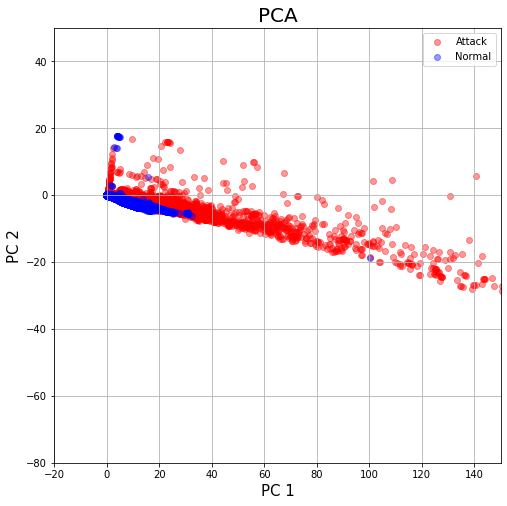

In [25]:
anom = np.array(result.filter(result['is_malicious'] == 1.0).rdd.map(lambda x: x['pcaFeatures']).collect()).T
norm = np.array(result.filter(result['is_malicious'] == 0.0).rdd.map(lambda x: x['pcaFeatures']).collect()).T

fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
ax.axis([-20, 150, -80, 50])
targets = ['Attack','Normal']
ax.scatter(anom[0]
               , anom[1]
               , c = 'r',alpha=0.4)
ax.scatter(norm[0]
               , norm[1]
               , c = 'b'
              ,alpha=0.4)

ax.legend(targets)
ax.grid()
plt.show()

From the graph above we can see that anomalous queries usually turns into an outliered points and normal queries usually stay on the same extents. Therefore we can use spark.ml models to help us achieve our goal.

---

# Train & Evaluate
The model that we will use is Logistic Regresssion

> On Training we wont be able to know what hyperparameters we shoud use, like regularisation parameters etc.
Spark provide a grid search algorithm to give us the model with the highest scores.

In [12]:
train, test = wordsData.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'is_malicious')


paramGrid = ParamGridBuilder().addGrid(lr.maxIter,[10,100,1000]).addGrid(lr.regParam, [0.1, 0.01,0.001])\
    .addGrid(lr.fitIntercept, [False, True]).addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(labelCol='is_malicious'),
                           trainRatio=0.8)
model = tvs.fit(train)


Training Dataset Count: 1047916
Test Dataset Count: 262337


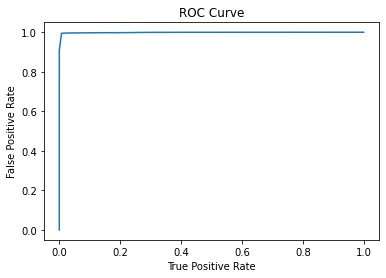

Training set areaUnderROC: 0.9988123537628646
Test Area accuracy 0.9988052477488654


In [13]:
trainingSummary = model.bestModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
print('Test Area accuracy', trainingSummary.accuracy)

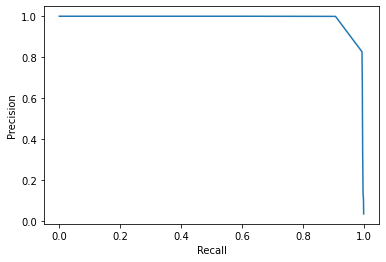

In [14]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    253468
         1.0       1.00      0.96      0.98      8869

    accuracy                           1.00    262337
   macro avg       1.00      0.98      0.99    262337
weighted avg       1.00      1.00      1.00    262337



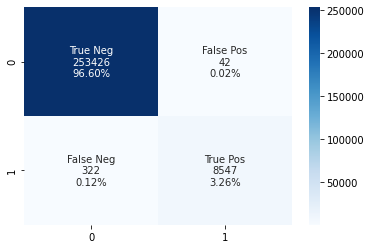

In [16]:
predictions = model.bestModel.transform(test)
y_true = predictions.select(['is_malicious']).collect()
y_pred = predictions.select(['prediction']).collect()

cf_matrix = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred))


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');


# Saving the models




In [0]:
model.bestModel.save('/content/drive/My Drive/Colab Notebooks/Bigdata/Logistic_Regression_Model')
tokenizer.save('/content/drive/My Drive/Colab Notebooks/Bigdata/Tokenizer')
vectorizer.save('/content/drive/My Drive/Colab Notebooks/Bigdata/Vectorizer')
idf_model.save('/content/drive/My Drive/Colab Notebooks/Bigdata/idf')
scalerModel.save('/content/drive/My Drive/Colab Notebooks/Bigdata/scalerModel')

# Test predictions

In [120]:
queries = sc.parallelize(['Alice','bigdata',"hellworld","select* from students where '1'='1","<sctipt></sctipt>"]).map(lambda q: Row(payload=q))
sample_df = sqlc.createDataFrame(queries)

sample_df = sample_df.withColumn('ngrams', ngrams(sample_df['payload']))
sample_df = tokenizer.transform(sample_df)
sample_df = vectorizer.transform(sample_df)
sample_df = idf_model.transform(sample_df)
sample_df = scalerModel.transform(sample_df).cache()
preds = model.bestModel.transform(sample_df)
sample_df.select('payload','scaledFeatures').show()


+--------------------+--------------------+
|             payload|      scaledFeatures|
+--------------------+--------------------+
|               Alice|(4472,[34,42,53,1...|
|             bigdata|(4472,[24,43,169,...|
|           hellworld|(4472,[23,75,86,9...|
|select* from stud...|(4472,[0,13,17,19...|
|   <sctipt></sctipt>|(4472,[3,6,7,27,1...|
+--------------------+--------------------+



In [119]:
preds = model.bestModel.transform(sample_df)
preds.select('payload','prediction').show(truncate=False)

+----------------------------------+----------+
|payload                           |prediction|
+----------------------------------+----------+
|Alice                             |0.0       |
|bigdata                           |0.0       |
|hellworld                         |0.0       |
|select* from students where '1'='1|1.0       |
|<sctipt></sctipt>                 |1.0       |
+----------------------------------+----------+

